In [1]:
import numpy as np
import csv
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
#from tensorflow.examples.tutorials.mnist import input_data
from torch.autograd import Variable
import sklearn.metrics as metrics
import pickle
import os
import numpy.linalg as la
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from utils import *

In [2]:
findex = 0
ip,labels = get_features(findex,cleaned=True)
labels = labels.astype(int)
ip,labels = shuffle(ip,labels)

In [3]:
batch_size = 150

no_ex,ip_dim = ip.shape
z_dim = 2
comb_dim = ip_dim + z_dim
print ip.shape

(3306, 144)


In [4]:
#### Encoder

class encoder(nn.Module):
    def __init__(self):
        super(encoder,self).__init__()
        self.l1 = nn.Linear(ip_dim,500)
        self.l2 = nn.Linear(500,500)
        self.l3 = nn.Linear(500,300)
        self.l4 = nn.Linear(300,300)
        self.l5 = nn.Linear(300,z_dim)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.leaky_relu(self.l4(x))
        x = (self.l5(x))
        
        return x

### Decoder

class decoder(nn.Module):
    def __init__(self):
        super(decoder,self).__init__()
        self.l1 = nn.Linear(z_dim+2,300)
        self.l2 = nn.Linear(300,300)
        self.l3 = nn.Linear(300,500)
        self.l4 = nn.Linear(500,500)
        self.l5 = nn.Linear(500,ip_dim)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.leaky_relu(self.l4(x))
        x = (self.l5(x))
        
        return x

###  Discriminator

class disc(nn.Module):
    def __init__(self):
        super(disc,self).__init__()
        self.l1 = nn.Linear(z_dim+2,500)
        self.l2 = nn.Linear(500,500)
        self.l3 = nn.Linear(500,100)
        self.l4 = nn.Linear(100,1)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.sigmoid(self.l4(x))
        
        return x
    
class disc2(nn.Module):
    def __init__(self):
        super(disc2,self).__init__()
        self.l1 = nn.Linear(ip_dim,500)
        self.l2 = nn.Linear(500,500)
        self.l3 = nn.Linear(500,100)
        self.l4 = nn.Linear(100,1)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.sigmoid(self.l4(x))
        
        return x

In [5]:
def add_label_info(y,batch_size,numpy=False):

    tmp = np.zeros((batch_size,2))
    if(numpy == False):
        y = y.cpu().data.numpy().reshape(batch_size,1)
    for i in range(y.shape[0]):
        tmp[i,y[i]] = 10
    label_info = torch.from_numpy((tmp))
    return label_info

In [6]:
def get_true_z(mean_z,label):
    
    noise = np.random.randn(batch_size,z_dim)
    label = label.data.cpu().numpy().reshape(batch_size,)
    #print noise.shape,label.shape
    #z = 0.1*noise + label*10
    
    z = 0.4*noise + mean_z[label]
    z = Variable(torch.FloatTensor(z))
    return z
    #z = torch.add(noise,value=1,other=label)
    #z = Variable(z.cuda())

In [20]:
#def train_model(Q,Q_solver,P,P_solver,D,D_solver,D2,D2_solver,batch_size,clustering = clustering,mean_z = mean_z):
def train_model(ip,labels,mean_z=None):
    
    recon = []
    encode = []
    discriminate = []
    for it in range(2,500):
        ind = get_train_ind(0,no_ex)
        x,y = get_train_batch(ip,labels,ind,batch_size)
       
        if(cuda==True):
            #x = Variable(x.cuda())
            label_info = Variable((add_label_info(y,batch_size)).type(torch.FloatTensor)).cuda()

        else:
            #x = Variable(x)
            label_info = Variable((add_label_info(y,batch_size)).type(torch.FloatTensor))

        z = Q(x)

        #Reconstruction

        z_false = (torch.cat([z,label_info],1))
        
        x_recon = P(z_false)
        
        add_small = 1e-20
        
        if(it%3==0):
            #CEL = F.binary_cross_entropy(x_recon,x)
            #CEL = criterion(x_recon, x)
            CEL = F.l1_loss(x_recon,x)
            CEL.backward(retain_graph=True)
            Q_solver.step()
            P_solver.step()
        
            Q.zero_grad()
            P.zero_grad()
        #recon.append(CEL)  
        
        #Discriminator
       
        
        if cuda==True:
            if mean_z is not None:
                z_true = get_true_z(mean_z,y).cuda()
            else:
                z_true = Variable(torch.randn(batch_size,z_dim).cuda())
                
        else:
            if mean_z is None:
                z_true = get_true_z(mean_z,y)
            else:
                z_true = Variable(torch.randn(batch_size,z_dim))

        z_true = Variable(torch.cat([z_true,label_info],1).data).cuda()
        z_true_op = D(z_true)
        
        z_false_op = D(z_false)
        
        
        if(it%2==0):
    
            loss_d = -torch.mean(torch.log(z_true_op + add_small) + torch.log(1 - z_false_op + add_small))
            loss_d.backward(retain_graph=True)
            D_solver.step()
            D.zero_grad()
            discriminate.append(loss_d)

    #Updating the encoder
        G_loss = -torch.mean(torch.log(z_false_op+1e-20))
        G_loss.backward(retain_graph=True)
        Q_solver.step()
        Q_solver.zero_grad()
        encode.append(G_loss)
        
        
    ## occasionally update the encoder with MSE loss
    
#         if(it%25==0):
#             tmp_loss = nn.MSELoss()(z_false,z_true)
#             print('tmp_loss:',tmp_loss.data[0])
#             tmp_loss = 1e-3*tmp_loss
#             tmp_loss.backward()
#             Q_solver.step()
#             Q_solver.zero_grad()

        
        
        if(it%25==0):
            #print(extra_loss.data[0],CEL.data[0])
            print('recon_loss:', CEL.data[0],'disc_loss:', loss_d.data[0])
            print('gen_loss: ',G_loss.data[0])#,'D2_loss',D2_loss.data[0])
#             plt.plot(range(1,it),np.array(discriminate).reshape(len(discriminate),1))
#             plt.title('discriminator loss')
#             plot.show()
            
            
#             plt.plot(range(1,it),np.array(encode).reshape(len(encode),1))
#             plt.title('encoder loss')
#             plot.show()
           
#             plt.plot(range(1,it),np.array(reconstruct).reshape(len(reconstruct),1))
#             plt.title('reconstruction loss')
#             plot.show()            
        
        ## plot the distribution ##
        if(it%25 == 0):
            ind = get_train_ind(val_iter=0,no_examples=no_ex)
            xt,yt = get_train_batch(ip,labels,ind,batch_size=1000)
            yt = yt.data.cpu().numpy()
            #xcheck = Variable(xcheck.view(1000,28*28).cuda())
            zhat = Q(xt)
            z_mu = zhat.cpu().data.numpy()
            plt.figure(figsize=(8, 6)) 
           
            plt.scatter(z_mu[:, 0], z_mu[:, 1],c = yt)#,cmap=plt.cm.autumn)
            plt.colorbar()
            plt.grid()
            plt.show()   
    #return Q,P

In [21]:
cuda = True
if(1==1):
    if cuda==True:
        Q = encoder().cuda()
        P = decoder().cuda()
        D = disc().cuda()
        D2 = disc2().cuda()
    else:
        Q = encoder()
        P = decoder()
        D = disc()
   
    Q_solver = optim.Adam(Q.parameters(),lr=1e-3)
    E_solver = optim.Adam(Q.parameters(),lr = 1e-3)
    
    P_solver = optim.Adam(P.parameters(),lr = 1e-3)
   
    D_solver = optim.Adam(D.parameters(),lr = 1e-3)
    D2_solver = optim.Adam(D2.parameters(),lr = 1e-3)
    #Q,P = train_model(Q,Q_solver,P,P_solver,D,D_solver,D2,D2_solver,batch_size,clustering = clustering)
    
 
    
    #return Q,P

('recon_loss:', 0.22892557084560394, 'disc_loss:', 1.9425441026687622)
('gen_loss: ', 0.21894994378089905)


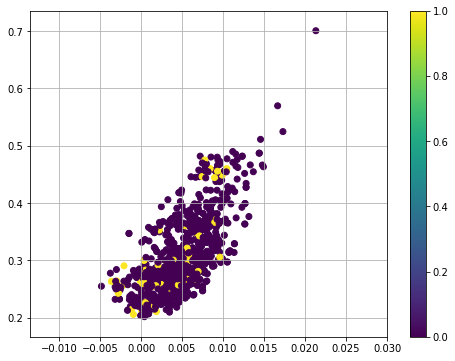

('recon_loss:', 0.2348083108663559, 'disc_loss:', 1.532366156578064)
('gen_loss: ', 0.31611984968185425)


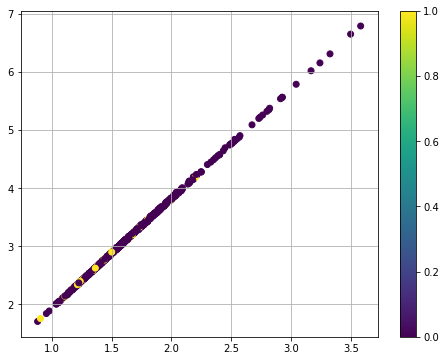

('recon_loss:', 0.2295558601617813, 'disc_loss:', 1.2695717811584473)
('gen_loss: ', 0.38426387310028076)


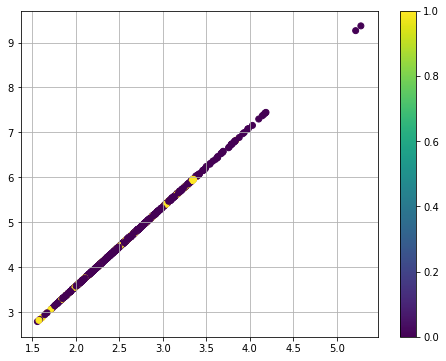

('recon_loss:', 0.23340967297554016, 'disc_loss:', 1.144604206085205)
('gen_loss: ', 0.385916531085968)


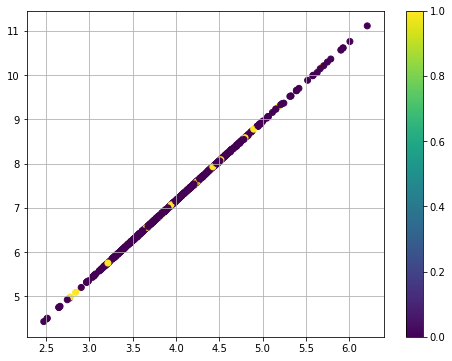

('recon_loss:', 0.2239091396331787, 'disc_loss:', 1.106766700744629)
('gen_loss: ', 0.3817012906074524)


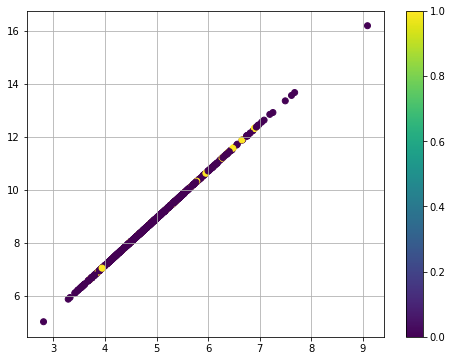

('recon_loss:', 0.22024895250797272, 'disc_loss:', 1.2155131101608276)
('gen_loss: ', 0.35202544927597046)


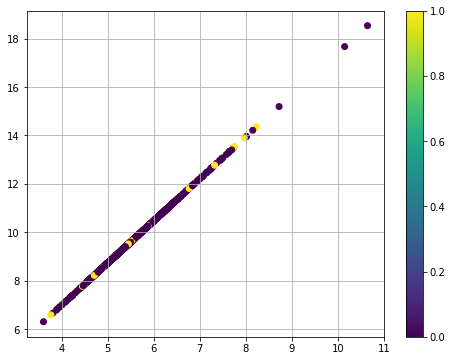

('recon_loss:', 0.23648476600646973, 'disc_loss:', 1.3222332000732422)
('gen_loss: ', 0.2879898250102997)


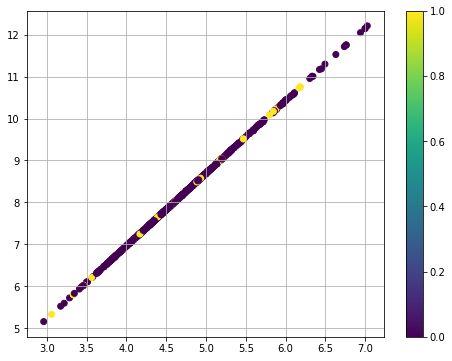

('recon_loss:', 0.22478660941123962, 'disc_loss:', 1.0269087553024292)
('gen_loss: ', 0.44364750385284424)


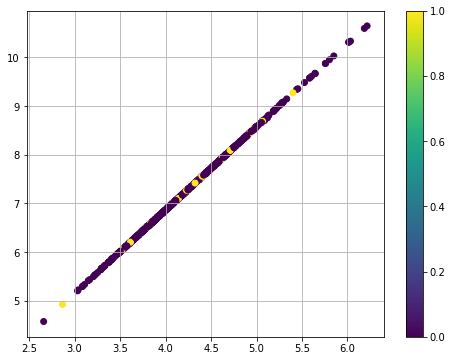

('recon_loss:', 0.21771879494190216, 'disc_loss:', 1.110177755355835)
('gen_loss: ', 0.4372652769088745)


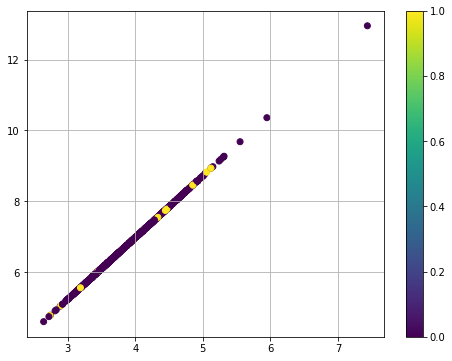

('recon_loss:', 0.2264430969953537, 'disc_loss:', 1.1459399461746216)
('gen_loss: ', 0.3829383850097656)


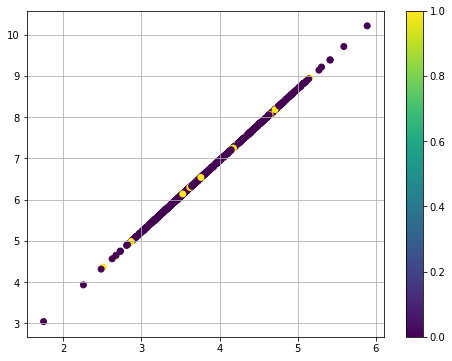

('recon_loss:', 0.23736830055713654, 'disc_loss:', 1.1294199228286743)
('gen_loss: ', 0.39426326751708984)


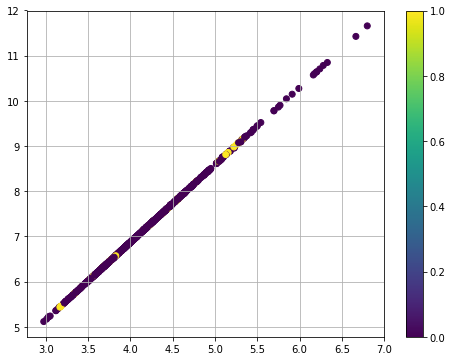

('recon_loss:', 0.22908230125904083, 'disc_loss:', 1.003045916557312)
('gen_loss: ', 0.45715153217315674)


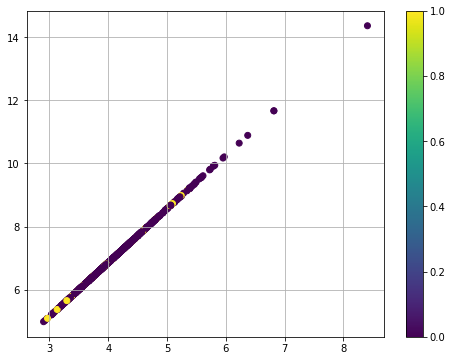

('recon_loss:', 0.23188161849975586, 'disc_loss:', 0.9631729125976562)
('gen_loss: ', 0.4815211594104767)


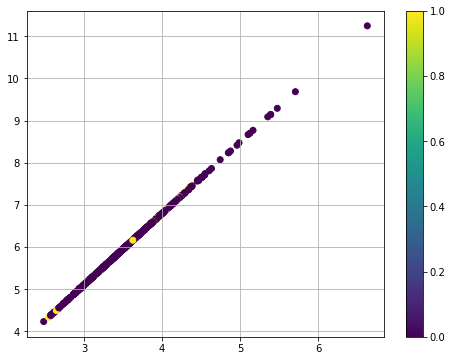

('recon_loss:', 0.2205522507429123, 'disc_loss:', 0.9856472611427307)
('gen_loss: ', 0.46757811307907104)


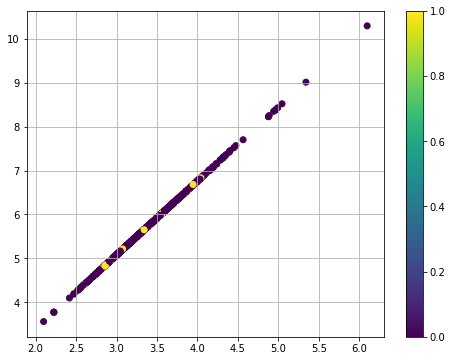

('recon_loss:', 0.22821500897407532, 'disc_loss:', 0.983345627784729)
('gen_loss: ', 0.453024297952652)


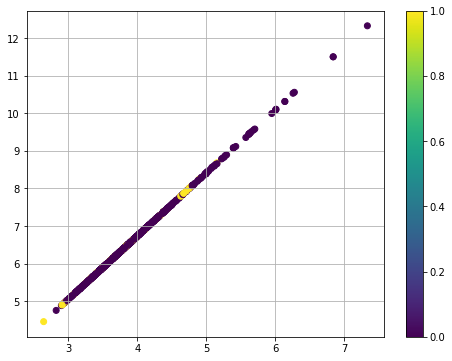

('recon_loss:', 0.24010154604911804, 'disc_loss:', 1.1077475547790527)
('gen_loss: ', 0.401511013507843)


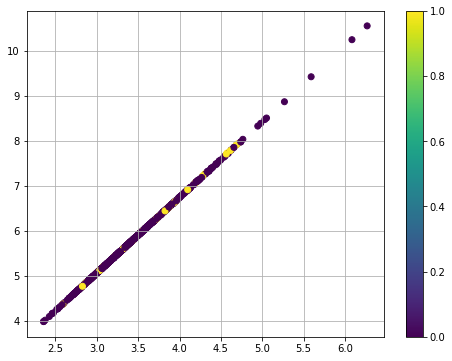

('recon_loss:', 0.2269333153963089, 'disc_loss:', 1.0922515392303467)
('gen_loss: ', 0.38704973459243774)


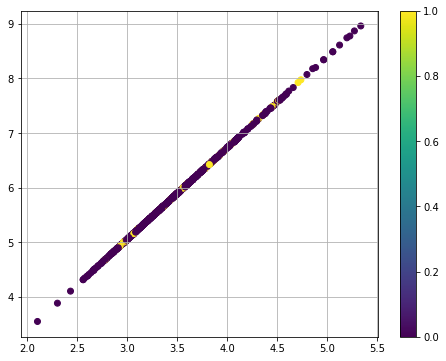

('recon_loss:', 0.2188507318496704, 'disc_loss:', 1.1716471910476685)
('gen_loss: ', 0.3709092438220978)


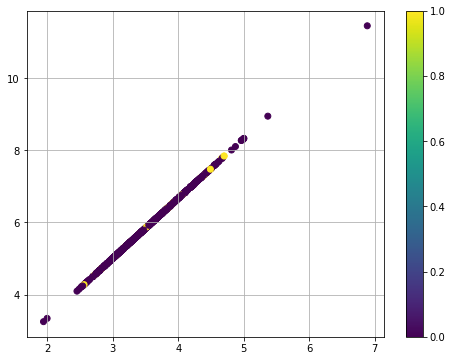

('recon_loss:', 0.22292517125606537, 'disc_loss:', 1.170893907546997)
('gen_loss: ', 0.3748292922973633)


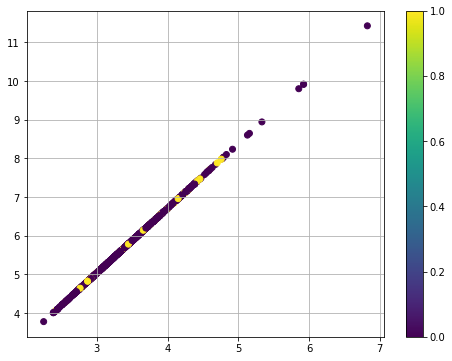

In [22]:
train_model(ip,labels)

In [10]:
def get_mean():
    ind = get_train_ind(val_iter=0,no_examples=no_ex)
    x,y = get_train_batch(ip,labels,ind,batch_size=1000)
    y = y.cpu().data.numpy()
    z = Q(x)
    z_np = z.cpu().data.numpy()
    mean_z = np.zeros((2,z_dim))
    
    plt.figure(figsize=(8, 6)) 
           
    plt.scatter(z_np[:, 0], z_np[:, 1],c = y)#,cmap=plt.cm.autumn)
    plt.colorbar()
    plt.grid()
    plt.show()   
    for i in range(2):
        mean_z[i] = np.mean(z_np[np.argwhere(y==i)],axis=0)
        #print(z_np[np.argwhere(y==i)])
    plt.scatter(mean_z[:,0],mean_z[:,1],c=range(2))
    plt.show()
    
    return mean_z

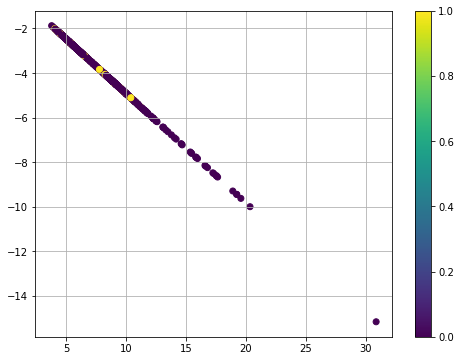

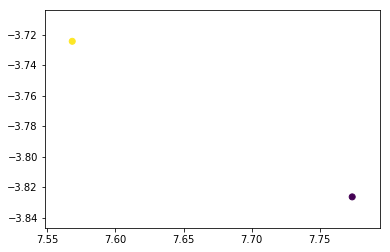

In [11]:
mean_z = get_mean()

('recon_loss:', 0.2316051572561264, 'disc_loss:', 0.8960110545158386)
('gen_loss: ', 0.5574391484260559)


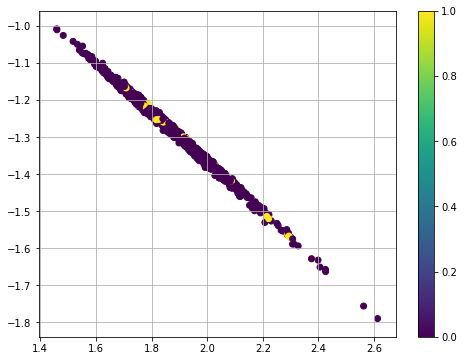

('recon_loss:', 0.22973336279392242, 'disc_loss:', 0.7152338624000549)
('gen_loss: ', 0.6729105710983276)


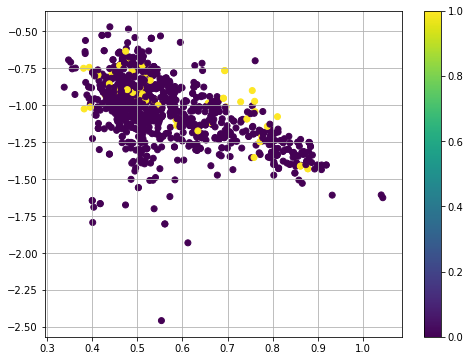

('recon_loss:', 0.22113235294818878, 'disc_loss:', 0.6801669597625732)
('gen_loss: ', 0.7063511610031128)


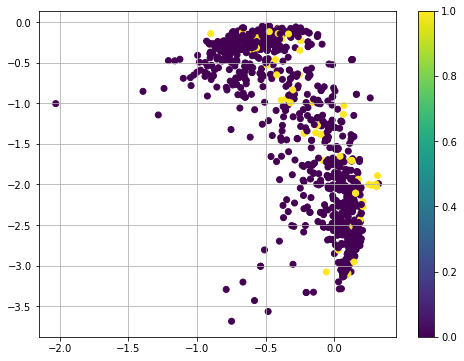

('recon_loss:', 0.20448631048202515, 'disc_loss:', 0.6937372088432312)
('gen_loss: ', 0.6925933957099915)


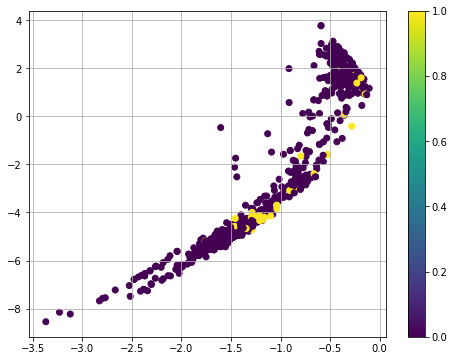

('recon_loss:', 0.20085085928440094, 'disc_loss:', 0.6920775175094604)
('gen_loss: ', 0.6942391991615295)


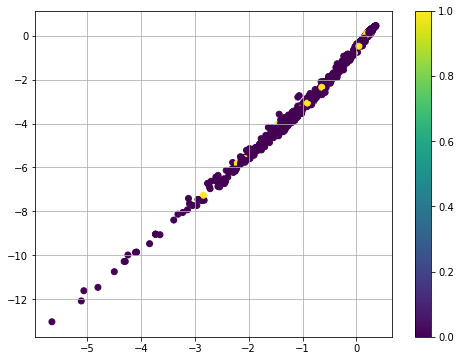

('recon_loss:', 0.18452617526054382, 'disc_loss:', 0.6931039094924927)
('gen_loss: ', 0.6932114958763123)


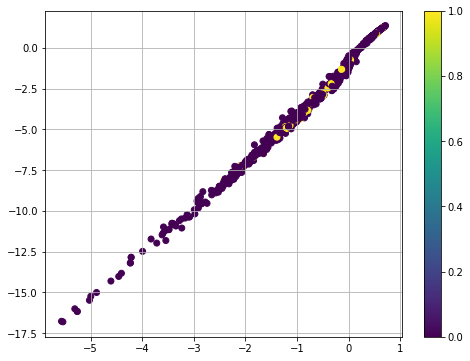

('recon_loss:', 0.1857246458530426, 'disc_loss:', 0.6932300329208374)
('gen_loss: ', 0.6930865049362183)


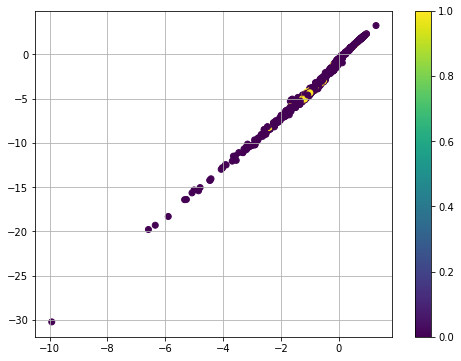

('recon_loss:', 0.17301085591316223, 'disc_loss:', 0.6920895576477051)
('gen_loss: ', 0.6942314505577087)


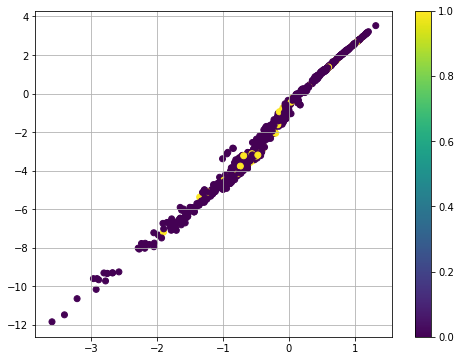

('recon_loss:', 0.17632628977298737, 'disc_loss:', 0.6930270195007324)
('gen_loss: ', 0.6932860612869263)


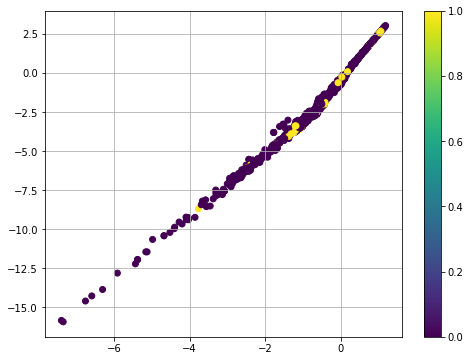

('recon_loss:', 0.17785640060901642, 'disc_loss:', 0.6932588219642639)
('gen_loss: ', 0.6930500864982605)


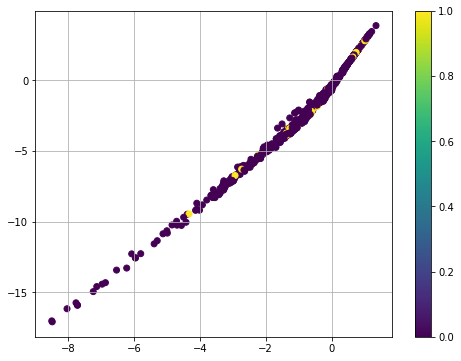

('recon_loss:', 0.17319725453853607, 'disc_loss:', 0.6932724118232727)
('gen_loss: ', 0.6930400729179382)


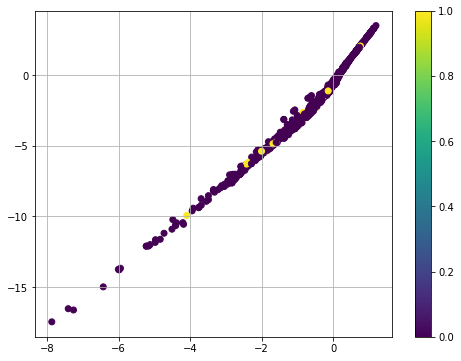

('recon_loss:', 0.16978175938129425, 'disc_loss:', 0.6930264830589294)
('gen_loss: ', 0.6932852864265442)


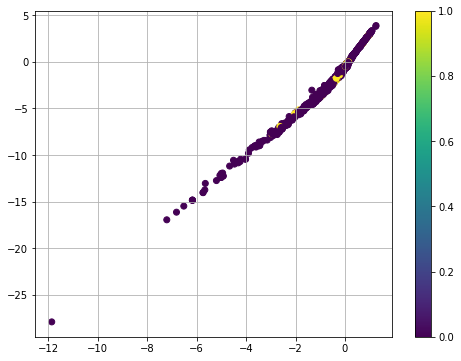

('recon_loss:', 0.16990701854228973, 'disc_loss:', 0.6931909322738647)
('gen_loss: ', 0.6931173801422119)


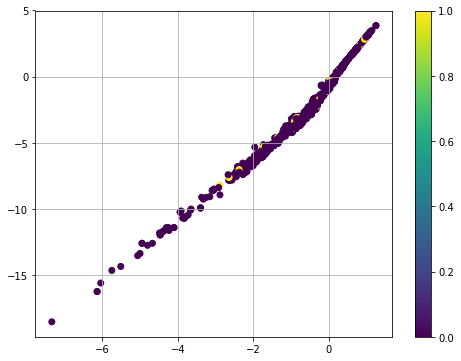

('recon_loss:', 0.16808757185935974, 'disc_loss:', 0.6928353905677795)
('gen_loss: ', 0.6934738755226135)


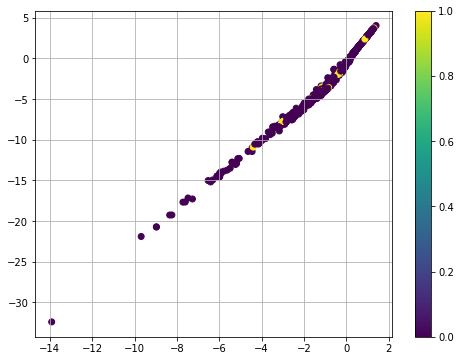

('recon_loss:', 0.1681189090013504, 'disc_loss:', 0.6933590173721313)
('gen_loss: ', 0.6929502487182617)


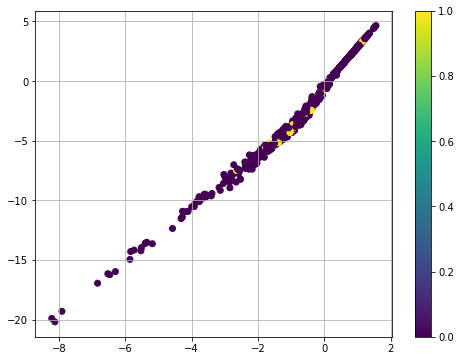

('recon_loss:', 0.16671624779701233, 'disc_loss:', 0.6931639313697815)
('gen_loss: ', 0.6931427717208862)


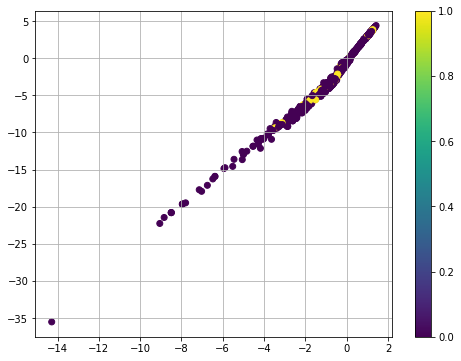

('recon_loss:', 0.16209296882152557, 'disc_loss:', 0.6930146217346191)
('gen_loss: ', 0.6932955980300903)


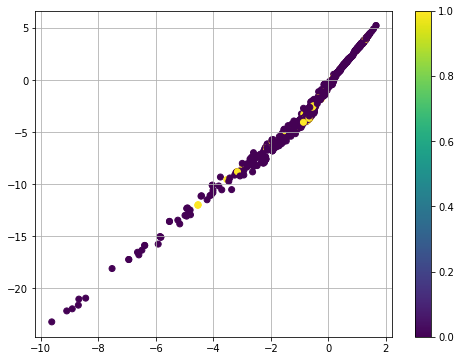

('recon_loss:', 0.16870537400245667, 'disc_loss:', 0.6924743056297302)
('gen_loss: ', 0.6938346028327942)


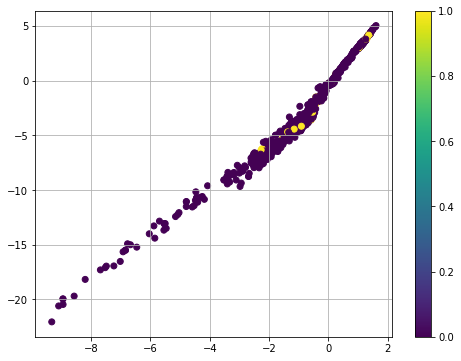

('recon_loss:', 0.1624927967786789, 'disc_loss:', 0.6931268572807312)
('gen_loss: ', 0.6931823492050171)


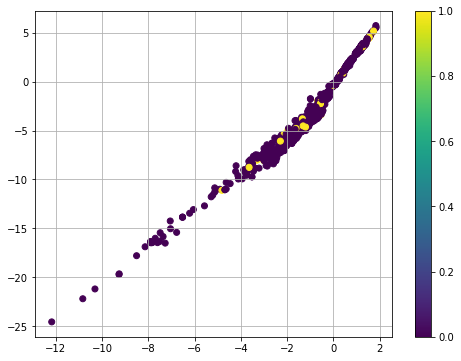

In [12]:
train_model(ip,labels,mean_z)

### Check on Test data 

In [13]:
xtest,ytest = get_features(findex,train=False)
xtest = Variable(torch.cuda.FloatTensor(xtest))
ztest = Q(xtest)
ztest_np = ztest.data.cpu().numpy()

In [14]:
ytest = ytest.reshape(ytest.shape[0],)

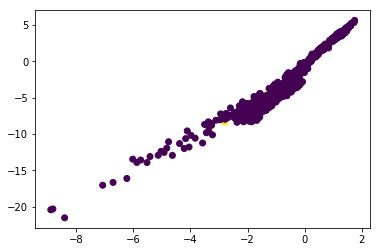

In [15]:

#ytest_np = ytest.data.cpu().numpy()
plt.scatter(ztest_np[:,0],ztest_np[:,1],c=ytest)
plt.show()

In [16]:
sum(ytest)

12

In [17]:
# if(1==1):
#     xcheck,labels = next(iter(test_loader))
#     labels2 = labels.numpy()
#     xcheck = Variable(xcheck.view(1000,28*28).cuda())
#     zhat = E(xcheck)
#     z_mu = zhat.cpu().data.numpy()
#     print labels2.shape
#     plt.figure(figsize=(8, 6)) 
#     #colors = cm.rainbow(np.linspace(0, 1, 10))
#     plt.scatter(z_mu[:, 0], z_mu[:, 1],c = labels2,cmap=plt.cm.hot)
#     plt.colorbar()
#     plt.grid()
#     plt.show()

In [18]:
# X_embedded = TSNE(n_components=2).fit_transform(z_mu)
# plt.figure(figsize=(8, 6)) 
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1],c = labels2,cmap=plt.cm.hot)
# plt.colorbar()
# plt.grid()
# plt.show()

In [19]:
# noise = np.random.randn(1,z_dim)
# label = 7
#     #print noise.shape,label.shape
# z = 0.5*noise + label*10
# z = Variable(torch.FloatTensor(z).cuda())
# op = G(z).cpu().data.numpy()
# op = op.reshape(28,28)
# plt.imshow(op)
# plt.show()